In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu May 18 20:39:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
import numpy as np
import cv2
import os
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
images = []
labels = []

In [8]:
# Load the FVC2000 dataset

train_dir = '/content/drive/MyDrive/Fingerprint/FVC2000_DB4_B/dataset/train_data'
for j in range(0, 10):
    for k in range(0, 80):
        path = '0000' + str(j) + '_';
        if k <= 9:
            path = path + '0';
        path = path + str(k) + '.bmp';
        img_path = os.path.join(train_dir, path)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error: Failed to read {img_path}")
            continue
        img = cv2.resize(img, (256, 256))
        img = np.expand_dims(img, axis=-1)

        images.append(img)
        labels.append(j)

In [9]:
images = np.array(images)
labels = np.array(labels)

In [10]:
# Function to create the CNN model
def create_model(activation='relu', optimizer='adam'):
    model = Sequential([
        Conv2D(32, (3, 3), activation=activation, input_shape=(256, 256, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation=activation),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation=activation),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation=activation),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10)
    ])

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [11]:
# Create a KerasClassifier based on the create_model function
model = KerasClassifier(build_fn=create_model, verbose=0)

<ipython-input-11-03852aaef225>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [12]:
# Define the hyperparameters to tune
param_grid = {
    'activation': ['relu', 'sigmoid'],
    'optimizer': ['adam', 'sgd']
}

In [13]:
# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(images, labels)

In [14]:
# Print the best hyperparameters and accuracy
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.333333 using {'activation': 'sigmoid', 'optimizer': 'sgd'}


In [15]:
# Access the best model from the grid search
best_model = grid_result.best_estimator_.model

In [16]:
best_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 batch_normalization_48 (Bat  (None, 254, 254, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_49 (Bat  (None, 125, 125, 64)     256       
 chNormalization)                                                
                                                     

In [17]:
# Train the best model with all the data
history = best_model.fit(images, labels, epochs=30)

Epoch 1/30
25/25 [==============================] - 2s 85ms/step - loss: 2.6798 - accuracy: 0.1525
Epoch 2/30
25/25 [==============================] - 2s 85ms/step - loss: 2.5961 - accuracy: 0.1625
Epoch 3/30
25/25 [==============================] - 2s 84ms/step - loss: 2.4089 - accuracy: 0.1813
Epoch 4/30
25/25 [==============================] - 2s 85ms/step - loss: 2.0740 - accuracy: 0.2962
Epoch 5/30
25/25 [==============================] - 2s 85ms/step - loss: 1.7964 - accuracy: 0.3950
Epoch 6/30
25/25 [==============================] - 2s 86ms/step - loss: 1.4913 - accuracy: 0.5150
Epoch 7/30
25/25 [==============================] - 2s 89ms/step - loss: 1.3204 - accuracy: 0.5900
Epoch 8/30
25/25 [==============================] - 2s 86ms/step - loss: 1.1589 - accuracy: 0.6275
Epoch 9/30
25/25 [==============================] - 2s 85ms/step - loss: 1.0780 - accuracy: 0.6400
Epoch 10/30
25/25 [==============================] - 2s 85ms/step - loss: 1.1022 - accuracy: 0.6438
Epoch 11/

In [18]:
best_model.save('/content/drive/MyDrive/Fingerprint/FVC2000_DB4_B/best_model_CNN_BN.h5')

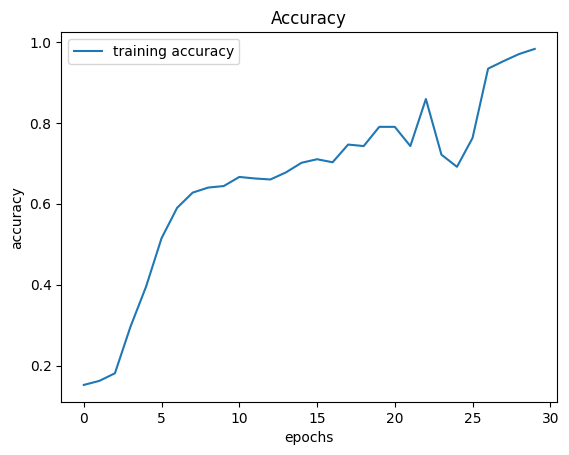

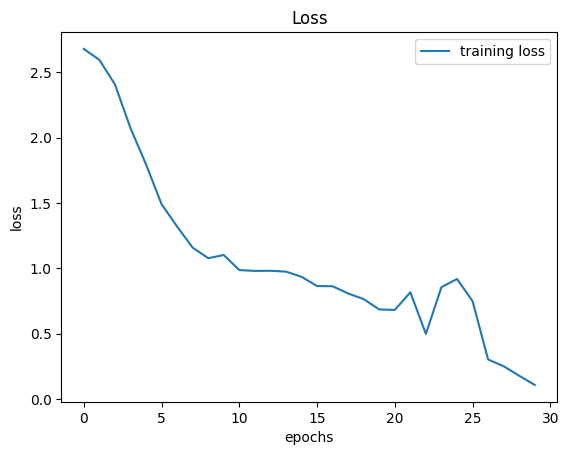

In [19]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
score = best_model.evaluate(images, labels, verbose=0)
print('accuracy:', score[1])

accuracy: 0.9975000023841858
